In [1]:
#!nvidia-smi
#using a GeForce GTX1080 Ti for reproducibility for all timing experiments

In [2]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score
import scipy
from utils.LB_utils import * 
from utils.load_not_MNIST import notMNIST
import os
import time
import matplotlib.pyplot as plt
from laplace import Laplace

s = 1
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
print("device: ", device)
print("cuda status: ", cuda_status)

device:  cuda
cuda status:  True


# Load data

In [4]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


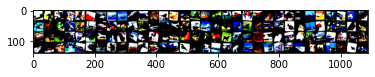

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


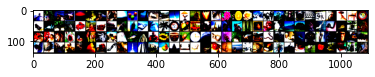

In [6]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

#'~/data/cifar100'
#CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
#                                       download=True, transform=transform_train)
#CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         #shuffle=True)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_test_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


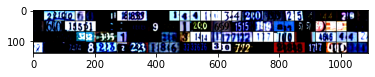

In [7]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

#'~/data/SVHN'
#train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
#                             download=False, transform=transform_train)

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=False, transform=transform_test)

#SVHN_train_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_test_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR10 on ResNet18 (or load weights)

In [8]:
#import torchvision.models as models
import resnet18_v2
CIFAR10_model = resnet18_v2.ResNet18().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#optimizer = optim.Adam(CIFAR10_model.parameters(), lr=0.01, weight_decay=5e-4)
MAX_EPOCHS=200
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.2)
best_acc = 0  # best test accuracy

In [10]:
# Training
def train(net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(CIFAR10_train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)

In [11]:
def test(net, path, save=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(CIFAR10_test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct/total
        if acc > best_acc and save: 
            best_acc = acc
            print("saving model at: {}".format(path))
            torch.save(net.state_dict(), path)


        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc) )

In [12]:
# We know that you should not validate on your test data but our paper is not about the training process
# but rather about what you can do once you have a well-trained model. 

def train_all():
    CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_s{}.pth'.format(s)
    CIFAR10_PATH_BEST = 'pretrained_weights/CIFAR10_resnet18_best_s{}.pth'.format(s)
    for epoch in range(MAX_EPOCHS):
        print('\nEpoch: %d' % epoch)
        train(CIFAR10_model)
        test(CIFAR10_model, save=True, path=CIFAR10_PATH_BEST)
        scheduler.step()
        

In [13]:
##### uncomment this if you want to train a network ######

#t0 = time.time()
#train_all()
#t1 = time.time()
#print("training took: {} seconds".format(t1-t0))

In [14]:
##### if you already have a trained model ##############
#CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_pretrained.pth'
CIFAR10_PATH = 'pretrained_weights/CIFAR10_resnet18_best_s{}.pth'.format(s)
CIFAR10_model = resnet18_v2.ResNet18().to(device)
print("loading model from: {}".format(CIFAR10_PATH))
CIFAR10_model.load_state_dict(torch.load(CIFAR10_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR10_model, save=False, path=CIFAR10_PATH)

loading model from: pretrained_weights/CIFAR10_resnet18_best_s1.pth
test loss:  15.19917606934905
current acc: 0.9517; best acc: 0


In [15]:
targets_CIFAR10 = CIFAR10_testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in SVHN_test_loader:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

In [16]:
#number of samples to draw from the Gaussian
num_samples = 100

# MAP estimate

In [17]:
CIFAR10_test_in_MAP = predict_MAP(CIFAR10_model, CIFAR10_test_loader, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_MAP = predict_MAP(CIFAR10_model, CIFAR100_test_loader, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_MAP = predict_MAP(CIFAR10_model, SVHN_test_loader, device=device).cpu().numpy()

In [18]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR10_test_in_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_SVHN_MAP, targets_SVHN)

In [19]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR10', 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'CIFAR10', 'SVHN', 'MAP')

[In, MAP, CIFAR10] Accuracy: 0.952; average entropy: 0.071;     MMC: 0.977; Prob @ correct: 0.100
[Out-CIFAR100, MAP, CIFAR10] Accuracy: 0.010; Average entropy: 0.517;    MMC: 0.818; AUROC: 0.874; Prob @ correct: 0.100
[Out-SVHN, MAP, CIFAR10] Accuracy: 0.112; Average entropy: 0.597;    MMC: 0.777; AUROC: 0.936; Prob @ correct: 0.100


# Diagonal estimate

In [20]:
la_diag = Laplace(CIFAR10_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='diag',
                     prior_precision=5e+0) # 5e-4 # Choose prior precision according to weight decay
la_diag.fit(CIFAR10_train_loader)

In [21]:
CIFAR10_test_in_D = predict_samples(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_D = predict_samples(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_D = predict_samples(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  3.4024444879999933
time:  9.527781136999998
time:  9.359329176999992


In [22]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR10_test_in_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_SVHN_D, targets_SVHN)

In [23]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR10', 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'CIFAR10', 'SVHN', 'Diag')

[In, Diag, CIFAR10] Accuracy: 0.951; average entropy: 0.289;     MMC: 0.928; Prob @ correct: 0.100
[Out-CIFAR100, Diag, CIFAR10] Accuracy: 0.010; Average entropy: 0.991;    MMC: 0.669; AUROC: 0.886; Prob @ correct: 0.100
[Out-SVHN, Diag, CIFAR10] Accuracy: 0.112; Average entropy: 1.129;    MMC: 0.596; AUROC: 0.945; Prob @ correct: 0.100


In [24]:
print(CIFAR10_test_in_D[0])

[9.0393511e-04 1.9845902e-03 9.5885794e-04 9.9131656e-01 3.0989866e-04
 1.1775825e-03 1.6703595e-03 9.1498747e-04 6.6868018e-04 9.4475166e-05]


# KFAC estimate

In [25]:
la_kron = Laplace(CIFAR10_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='kron',
                     prior_precision=1e-1) # 5e-4 # Choose prior precision according to weight decay
la_kron.fit(CIFAR10_train_loader)

/home/marius/anaconda3/lib/python3.9/site-packages/laplace/utils.py:137: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)
  L, W = torch.symeig(M, eigenvectors=True)


In [26]:
CIFAR10_test_in_KFAC = predict_samples(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_KFAC = predict_samples(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_KFAC = predict_samples(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  3.0140383060000033
time:  9.933286765000005
time:  10.932512528000004


In [27]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(CIFAR10_test_in_KFAC, targets_CIFAR10)
acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K = get_out_dist_values(CIFAR10_test_in_KFAC, CIFAR10_test_out_CIFAR100_KFAC, targets_CIFAR100)
acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K = get_out_dist_values(CIFAR10_test_in_KFAC, CIFAR10_test_out_SVHN_KFAC, targets_SVHN)

In [28]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'CIFAR10', 'KFAC')
print_out_dist_values(acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K, 'CIFAR10', 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K, 'CIFAR10', 'SVHN', 'KFAC')

[In, KFAC, CIFAR10] Accuracy: 0.951; average entropy: 0.201;     MMC: 0.944; Prob @ correct: 0.100
[Out-CIFAR100, KFAC, CIFAR10] Accuracy: 0.009; Average entropy: 0.925;    MMC: 0.684; AUROC: 0.878; Prob @ correct: 0.100
[Out-SVHN, KFAC, CIFAR10] Accuracy: 0.111; Average entropy: 1.245;    MMC: 0.559; AUROC: 0.955; Prob @ correct: 0.100


# Laplace Bridge estimate

In [29]:
CIFAR10_test_in_LB_D = predict_LB(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_LB_D = predict_LB(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_LB_D = predict_LB(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

step0, f_mu[0]:  tensor([-0.7904, -0.9332, -1.2690, 10.5045, -1.5545,  0.2727, -1.2620, -1.6380,
        -1.6235, -1.7063], device='cuda:0')
step0, f_var[0]:  tensor([[7.3171, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 7.8437, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 6.9209, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.6104, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 7.1798, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.7733, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.2872, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.4371, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-1.6891, -1.7921, -0.8434, 12.4825, -0.8778, -0.3672, -0.3515, -2.1753,
        -2.4925, -1.8933], device='cuda:0')
step0, f_var[0]:  tensor([[10.3962,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, 11.1437,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.4497,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  6.4476,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  9.7808,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  8.2501,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.8620,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 10.451

step0, f_mu[0]:  tensor([-1.8739,  9.1388, -2.1017, -1.3611, -2.3879, -2.3534, -0.6189, -1.8733,
         1.7749,  1.6568], device='cuda:0')
step0, f_var[0]:  tensor([[5.7224, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.9853, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 6.2543, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.8764, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.4401, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.2374, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.1036, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.4126, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.5678, -1.4108, -1.6946,  0.3151, -1.5208, 11.6893, -0.2370, -0.6316,
        -2.1915, -1.7500], device='cuda:0')
step0, f_var[0]:  tensor([[8.8620, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 9.0529, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 8.2780, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 6.1038, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 7.9839, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3429, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 8.3796, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 8.0258, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-1.4941, -2.7515, -0.4792, 10.3814, -1.9512,  0.2394, -1.5120,  0.9012,
        -2.1818, -1.1520], device='cuda:0')
step0, f_var[0]:  tensor([[7.5990, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 8.2882, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 6.9461, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.6823, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 7.2348, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.8548, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.5314, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.1364, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-0.1399, -1.7111, -0.0772,  0.2264, -1.6333,  8.9876, -1.3220, -1.1606,
        -0.6958, -2.4737], device='cuda:0')
step0, f_var[0]:  tensor([[5.9125, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 6.4428, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.5538, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.3779, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.6417, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9436, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.0281, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.7528, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.2934, -2.0892, -1.4223,  1.1657, -0.0288, 10.6590, -0.4897, -2.0035,
        -2.5509, -0.9465], device='cuda:0')
step0, f_var[0]:  tensor([[7.6628, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 7.9617, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 7.0903, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.1796, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.7157, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.6544, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.2259, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.2256, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-1.2047, -1.9819, -0.7687, -1.5803,  9.2386, -1.4312, -1.6287,  1.6013,
        -1.2082, -1.0360], device='cuda:0')
step0, f_var[0]:  tensor([[5.9038, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 6.3578, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.4957, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.2788, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.1252, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3604, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.9844, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0733, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 0.8735, -0.8217, -2.8770, -0.7702, -1.3268, -1.4679, -1.6512, -1.5375,
         9.4992,  0.0798], device='cuda:0')
step0, f_var[0]:  tensor([[5.3076, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.8521, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 6.1284, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.6728, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.2641, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.0598, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.3297, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.4256, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-1.7159, -1.8953, 10.8106, -0.2312, -1.7281, -1.4919, -1.3695,  0.2608,
        -0.5043, -2.1349], device='cuda:0')
step0, f_var[0]:  tensor([[7.7018, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 8.6409, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.8767, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 6.6902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 7.5976, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.3987, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.9221, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.7361, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-0.0967, -2.7701, -1.7701, -0.8304, -1.2812,  0.1348, -1.3899,  5.7269,
        -0.7515,  3.0284], device='cuda:0')
step0, f_var[0]:  tensor([[4.2003, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.6176, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.3650, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.8717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.2337, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9731, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.5860, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.6828, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 1.9990,  0.1471,  0.1855,  0.5382, -1.4492, -3.2559, -1.1499, -0.9224,
        -2.0426,  5.9505], device='cuda:0')
step0, f_var[0]:  tensor([[4.3484, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.4881, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.7283, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.4178, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.0362, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9388, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0320, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9991, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-1.4646,  0.5659,  0.8361,  6.2741, -2.3833,  2.1155,  0.7501, -3.3530,
        -4.1542,  0.8138], device='cuda:0')
step0, f_var[0]:  tensor([[6.1345, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 6.1396, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.5750, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.0965, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.0476, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.7634, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.7535, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.3492, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-0.9404, -3.0656,  1.3214,  2.7320,  0.2880, -1.1344, -1.0183,  4.1516,
        -2.1113, -0.2228], device='cuda:0')
step0, f_var[0]:  tensor([[3.7645, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.1941, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.3834, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.9207, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.4387, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.3434, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.8587, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.2372, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 3.9346,  1.1585, -2.1198, -2.2162,  0.5249, -1.7108, -1.8623, -0.7479,
         3.3923, -0.3530], device='cuda:0')
step0, f_var[0]:  tensor([[2.5603, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.0817, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.2548, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.2760, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.2807, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4336, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.5325, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4151, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 4.4830, -0.3414, -1.0100, -0.5800, -1.8447, -0.4662, -0.1544, -1.7042,
        -3.1855,  4.8037], device='cuda:0')
step0, f_var[0]:  tensor([[4.0551, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.5924, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.7036, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.3912, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.9765, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.7007, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.8786, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9810, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.7433,  1.6347,  3.8506, -0.7190, -1.6135, -2.3408,  1.4239,  3.3485,
        -2.0439, -0.7968], device='cuda:0')
step0, f_var[0]:  tensor([[4.6296, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.5141, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.9173, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.0215, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.4138, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.3807, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.3612, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.1924, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-0.6209, -0.6083,  0.5004,  8.3646, -1.6244, -1.7298,  1.0796, -2.2057,
        -3.2829,  0.1278], device='cuda:0')
step0, f_var[0]:  tensor([[6.6256, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 7.0034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.9945, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.4790, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.5073, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.7329, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.2490, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.9039, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-3.1507, -2.3127, -1.0915,  4.5262,  3.8063,  1.3638, -0.7597,  0.1763,
        -1.6325, -0.9253], device='cuda:0')
step0, f_var[0]:  tensor([[4.2188, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.4219, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.7635, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.7502, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.2720, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.1149, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9258, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7670, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 4.2386, -1.3820, -1.5122,  3.3474, -4.1912,  3.1877,  0.0553, -0.3916,
        -3.3920,  0.0403], device='cuda:0')
step0, f_var[0]:  tensor([[5.0760, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 6.0404, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.4483, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.1775, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.8587, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.4945, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.6838, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.6755, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 5.7204, -2.2063, -2.2547,  4.4048, -3.5681,  4.1805, -0.3900, -1.2119,
        -2.5297, -2.1447], device='cuda:0')
step0, f_var[0]:  tensor([[6.3933, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 7.8932, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 6.9840, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.1286, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 7.3677, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.5607, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.2887, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.3246, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 5.5007, -0.8345, -2.3117,  2.3102, -3.8558,  3.6739,  0.2177, -0.4161,
        -2.6033, -1.6807], device='cuda:0')
step0, f_var[0]:  tensor([[5.4700, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 6.6291, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 6.0695, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.7902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.4419, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0751, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.2888, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.2887, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 1.1212, -1.3214, -0.3258,  0.3542, -2.9062,  3.9858,  0.5543,  1.1517,
        -2.3134, -0.3000], device='cuda:0')
step0, f_var[0]:  tensor([[3.5165, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.9017, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.4493, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.8914, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.6642, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.8424, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.6286, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4681, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 7.3688, -0.9553,  0.1130,  0.8895, -3.1080,  0.8029, -1.6401,  0.2865,
        -2.3197, -1.4372], device='cuda:0')
step0, f_var[0]:  tensor([[4.5386, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.9574, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.2064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.7992, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.8649, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.1627, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.9455, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.6992, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-1.6448, -2.5951,  1.1156,  6.4644, -1.5728,  0.2711,  2.5315, -0.2785,
        -1.5241, -2.7671], device='cuda:0')
step0, f_var[0]:  tensor([[4.9459, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.4351, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.2570, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.1578, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.6103, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9119, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.3129, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.7960, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 2.9563, -1.1335, -2.1111,  3.3671, -2.0521,  4.5616, -0.9451, -0.5616,
        -3.6258, -0.4555], device='cuda:0')
step0, f_var[0]:  tensor([[4.8551, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.5593, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.0922, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.7319, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.1772, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9080, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3068, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.1879, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 5.2502, -1.9077,  1.4830,  0.9287, -3.1458,  2.0230, -1.6643,  1.6016,
        -2.8297, -1.7387], device='cuda:0')
step0, f_var[0]:  tensor([[4.5255, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.7574, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.7254, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.3566, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.3750, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.5693, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.5357, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0866, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 5.6876, -1.5249, -1.9421,  7.2487, -2.4667,  0.9171, -0.0612, -1.4311,
        -3.5286, -2.8984], device='cuda:0')
step0, f_var[0]:  tensor([[7.2376, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 8.8100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 7.7931, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.7004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 8.1781, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.6705, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 8.1335, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 8.2933, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 7.1227, -1.8593, -0.4412,  0.8187, -3.5503,  2.4506, -1.3910,  0.3191,
        -2.5471, -0.9218], device='cuda:0')
step0, f_var[0]:  tensor([[5.1164, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 6.6400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.7756, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.1181, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.4101, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3870, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.4695, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.1737, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 0.9294, -0.1139, -0.4284, -2.5427, -1.7181,  0.7168,  2.7665, -0.0260,
        -0.6540,  1.0708], device='cuda:0')
step0, f_var[0]:  tensor([[2.7407, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.9059, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.8135, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.6908, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.9647, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7628, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.6673, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.9546, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 7.0420, -2.2503, -2.0737,  4.6718, -3.7263,  1.9551,  0.3922, -0.7806,
        -3.2571, -1.9727], device='cuda:0')
step0, f_var[0]:  tensor([[6.7656, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 8.5539, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 7.5543, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.8413, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 8.0839, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.5317, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.8709, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.9682, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 4.3691, -2.4240, -1.9631,  2.8613, -2.5105,  4.1382, -0.3105, -0.9547,
        -2.3829, -0.8224], device='cuda:0')
step0, f_var[0]:  tensor([[4.6725, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.6811, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.0453, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.8083, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.2414, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.0176, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.2417, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.2451, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 4.3462, -2.5727,  0.2507,  1.4123, -3.1406,  5.9650, -1.3717, -0.3587,
        -3.2176, -1.3125], device='cuda:0')
step0, f_var[0]:  tensor([[5.9530, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 7.1772, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 6.0534, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.9870, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.5734, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9959, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.7400, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.4654, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 7.9158, -2.2410, -2.2426,  4.6582, -3.4502,  2.8005, -0.4802, -1.5070,
        -3.0613, -2.3918], device='cuda:0')
step0, f_var[0]:  tensor([[7.6175, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 9.7072, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 8.6035, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 6.6366, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 9.1666, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.3282, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 9.0958, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 9.1628, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 7.4849, -1.8869, -1.6105,  5.3344, -2.6891,  1.1179, -1.4297, -1.4534,
        -2.1587, -2.7085], device='cuda:0')
step0, f_var[0]:  tensor([[6.4810, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 8.2915, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 7.3422, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.7133, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 7.8190, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.4695, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.9543, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.8537, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 1.6543, -3.5619,  4.5816,  3.6155, -0.4402, -1.7914, -1.0726, -0.5532,
        -0.4141, -2.0177], device='cuda:0')
step0, f_var[0]:  tensor([[4.5292, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.5436, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.9767, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.8185, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.6706, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.5225, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9498, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9308, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 3.6328, -1.6301,  0.8456,  3.1832, -1.7790,  4.1145, -2.4121, -1.7556,
        -2.4711, -1.7279], device='cuda:0')
step0, f_var[0]:  tensor([[4.4233, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.3428, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.4594, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.5485, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.8581, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7466, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.1441, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0061, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 3.2635, -2.3503,  1.1358,  3.3979, -2.1582,  3.9706, -2.5486, -0.0430,
        -2.5713, -2.0961], device='cuda:0')
step0, f_var[0]:  tensor([[4.8132, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.8294, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.7767, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.8170, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.2100, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.0368, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.5352, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.1668, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 2.8816, -2.8173, -0.0367,  4.0835, -2.4728,  1.9946,  1.1286, -0.3306,
        -2.3749, -2.0558], device='cuda:0')
step0, f_var[0]:  tensor([[4.0512, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.9028, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.0591, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.1194, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.3905, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.5111, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.2262, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.3897, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 4.7802, -2.9304,  1.3747,  4.0458, -1.0356,  1.2057, -1.7604, -1.1729,
        -2.1773, -2.3295], device='cuda:0')
step0, f_var[0]:  tensor([[4.5121, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.7812, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.6255, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.8890, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.0583, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.3746, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3784, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.2483, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 6.2934, -2.5608, -2.0328,  4.7034, -2.7161,  1.9282, -0.2338, -1.4927,
        -1.8575, -2.0308], device='cuda:0')
step0, f_var[0]:  tensor([[5.6570, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 7.1883, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 6.3047, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.8034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.6656, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3889, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.6312, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.7141, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 4.6740, -1.5202, -1.8301,  8.0443, -2.1269, -0.0242, -0.8254, -1.3217,
        -2.6659, -2.4035], device='cuda:0')
step0, f_var[0]:  tensor([[6.8115, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 8.1471, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 7.2507, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.2221, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 7.5548, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.2603, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.6339, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.6686, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_var[0]:  tensor([[4.0094, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.0906, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.2032, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.8130, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.8014, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.1648, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9288, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.8369, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.8259,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         4

In [30]:
print(CIFAR10_test_in_LB_D[0])

[5.1767023e-05 4.7680573e-05 5.1119412e-05 9.9953181e-01 4.8200967e-05
 8.3175080e-05 4.8870839e-05 4.6425699e-05 4.5399694e-05 4.5596233e-05]


In [31]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(CIFAR10_test_in_LB_D, targets_CIFAR10)
acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB = get_out_dist_values(CIFAR10_test_in_LB_D, CIFAR10_test_out_CIFAR100_LB_D, targets_CIFAR100)
acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB = get_out_dist_values(CIFAR10_test_in_LB_D, CIFAR10_test_out_SVHN_LB_D, targets_SVHN)

In [32]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB, 'CIFAR10', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB, 'CIFAR10', 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR10] Accuracy: 0.952; average entropy: 0.108;     MMC: 0.971; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, CIFAR10] Accuracy: 0.010; Average entropy: 0.693;    MMC: 0.785; AUROC: 0.859; Prob @ correct: 0.100
[Out-SVHN, Laplace Bridge, CIFAR10] Accuracy: 0.113; Average entropy: 0.721;    MMC: 0.756; AUROC: 0.927; Prob @ correct: 0.100


# Laplace Bridge KFAC estimate

In [33]:
CIFAR10_test_in_LB_KFAC = predict_LB(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_LB_KFAC = predict_LB(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_LB_KFAC = predict_LB(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()

step0, f_mu[0]:  tensor([-0.7904, -0.9332, -1.2690, 10.5045, -1.5545,  0.2727, -1.2620, -1.6380,
        -1.6235, -1.7063], device='cuda:0')
step0, f_var[0]:  tensor([[48.4784, 44.8017, 45.0388, 44.7829, 44.7479, 44.6975, 44.7684, 44.7166,
         45.2378, 44.9079],
        [44.8017, 49.1731, 44.6310, 44.6422, 44.5598, 44.5946, 44.7039, 44.5787,
         45.0004, 45.4931],
        [45.0388, 44.6310, 48.4136, 44.9489, 45.0392, 44.8898, 44.9395, 44.8622,
         44.7481, 44.6670],
        [44.7829, 44.6422, 44.9489, 47.9206, 44.9921, 45.5188, 44.9832, 44.9894,
         44.6845, 44.7148],
        [44.7479, 44.5598, 45.0392, 44.9921, 48.5897, 45.0404, 44.8786, 45.0961,
         44.6330, 44.6008],
        [44.6975, 44.5946, 44.8898, 45.5188, 45.0404, 48.2214, 44.8557, 45.0780,
         44.6247, 44.6563],
        [44.7684, 44.7039, 44.9395, 44.9832, 44.8786, 44.8557, 48.9417, 44.7256,
         44.7083, 44.6727],
        [44.7166, 44.5787, 44.8622, 44.9894, 45.0961, 45.0780, 44.7256, 48.875

step0, f_var[0]:  tensor([[66.0408, 63.0750, 63.3012, 63.0455, 63.0117, 62.9618, 63.0341, 62.9781,
         63.5106, 63.1802],
        [63.0750, 66.7647, 62.8868, 62.8965, 62.8082, 62.8458, 62.9613, 62.8274,
         63.2863, 63.7878],
        [63.3012, 62.8868, 65.9738, 63.2182, 63.3103, 63.1637, 63.2105, 63.1354,
         63.0128, 62.9264],
        [63.0455, 62.8965, 63.2182, 65.5163, 63.2677, 63.7636, 63.2517, 63.2660,
         62.9428, 62.9703],
        [63.0117, 62.8082, 63.3103, 63.2677, 66.1546, 63.3177, 63.1512, 63.3753,
         62.8885, 62.8535],
        [62.9618, 62.8458, 63.1637, 63.7636, 63.3177, 65.8076, 63.1302, 63.3563,
         62.8807, 62.9108],
        [63.0341, 62.9613, 63.2105, 63.2517, 63.1512, 63.1302, 66.5027, 62.9955,
         62.9691, 62.9320],
        [62.9781, 62.8274, 63.1354, 63.2660, 63.3753, 63.3563, 62.9955, 66.4425,
         62.8678, 62.8944],
        [63.5106, 63.2863, 63.0128, 62.9428, 62.8885, 62.8807, 62.9692, 62.8678,
         66.4109, 63.3695],
 

step0, f_mu[0]:  tensor([-0.8401, -0.7989, 10.2134, -0.0899, -1.9467, -1.7055, -0.5744, -1.6689,
        -1.1256, -1.4633], device='cuda:0')
step0, f_var[0]:  tensor([[47.6914, 41.8951, 42.2869, 41.8796, 41.8223, 41.7417, 41.8524, 41.7756,
         42.5896, 42.0654],
        [41.8951, 48.7566, 41.6471, 41.6671, 41.5440, 41.5957, 41.7610, 41.5738,
         42.1941, 42.9660],
        [42.2870, 41.6471, 47.5910, 42.1345, 42.2759, 42.0347, 42.1173, 41.9915,
         41.8214, 41.6996],
        [41.8796, 41.6671, 42.1345, 46.7623, 42.1949, 43.0718, 42.1900, 42.1894,
         41.7290, 41.7811],
        [41.8223, 41.5440, 42.2759, 42.1949, 47.8648, 42.2695, 42.0184, 42.3555,
         41.6509, 41.6035],
        [41.7417, 41.5957, 42.0347, 43.0718, 42.2695, 47.2525, 41.9795, 42.3278,
         41.6368, 41.6895],
        [41.8524, 41.7610, 42.1173, 42.1900, 42.0184, 41.9795, 48.4302, 41.7785,
         41.7632, 41.7088],
        [41.7756, 41.5738, 41.9916, 42.1894, 42.3555, 42.3278, 41.7785, 48.316

step0, f_mu[0]:  tensor([-0.2938, -2.2932, 10.5960, -0.3291, -1.2177, -0.5430, -1.1942, -1.1274,
        -1.5990, -1.9983], device='cuda:0')
step0, f_var[0]:  tensor([[43.9788, 41.8413, 41.9762, 41.8265, 41.8060, 41.7766, 41.8187, 41.7872,
         42.0958, 41.9029],
        [41.8413, 44.3962, 41.7351, 41.7408, 41.6906, 41.7118, 41.7781, 41.7016,
         41.9621, 42.2531],
        [41.9762, 41.7351, 43.9406, 41.9261, 41.9794, 41.8924, 41.9207, 41.8764,
         41.8061, 41.7572],
        [41.8265, 41.7408, 41.9261, 43.6572, 41.9531, 42.2568, 41.9461, 41.9518,
         41.7672, 41.7840],
        [41.8060, 41.6906, 41.9794, 41.9531, 44.0457, 41.9820, 41.8858, 42.0152,
         41.7361, 41.7161],
        [41.7766, 41.7118, 41.8924, 42.2568, 41.9820, 43.8326, 41.8725, 42.0043,
         41.7314, 41.7490],
        [41.8187, 41.7781, 41.9207, 41.9461, 41.8858, 41.8725, 44.2495, 41.7957,
         41.7820, 41.7605],
        [41.7872, 41.7016, 41.8764, 41.9518, 42.0152, 42.0043, 41.7957, 44.213

step0, f_mu[0]:  tensor([-2.1968, -1.3794, -1.0986, -0.9816,  0.3432, 10.1340,  0.6410, -1.3464,
        -2.3868, -1.7282], device='cuda:0')
step0, f_var[0]:  tensor([[46.9837, 42.7685, 43.0475, 42.7468, 42.7053, 42.6461, 42.7294, 42.6688,
         43.2807, 42.8932],
        [42.7685, 47.7991, 42.5685, 42.5816, 42.4850, 42.5257, 42.6539, 42.5071,
         43.0015, 43.5798],
        [43.0475, 42.5685, 46.9079, 42.9417, 43.0476, 42.8716, 42.9302, 42.8395,
         42.7053, 42.6105],
        [42.7468, 42.5816, 42.9417, 46.3227, 42.9919, 43.6160, 42.9822, 42.9887,
         42.6312, 42.6671],
        [42.7053, 42.4850, 43.0476, 42.9919, 47.1149, 43.0487, 42.8588, 43.1140,
         42.5709, 42.5330],
        [42.6461, 42.5257, 42.8716, 43.6160, 43.0487, 46.6783, 42.8314, 43.0927,
         42.5610, 42.5981],
        [42.7294, 42.6539, 42.9302, 42.9821, 42.8588, 42.8314, 47.5282, 42.6793,
         42.6591, 42.6173],
        [42.6689, 42.5072, 42.8395, 42.9887, 43.1140, 43.0927, 42.6793, 47.450

step0, f_mu[0]:  tensor([-0.3458, -0.5487, -1.6540, -1.9694, -1.2622, -1.6636, -1.0400, -0.5198,
        -0.1668,  9.1705], device='cuda:0')
step0, f_var[0]:  tensor([[36.8814, 33.7487, 33.9328, 33.7351, 33.7075, 33.6685, 33.7233, 33.6837,
         34.0855, 33.8308],
        [33.7487, 37.4165, 33.6180, 33.6266, 33.5634, 33.5900, 33.6740, 33.5779,
         33.9014, 34.2812],
        [33.9328, 33.6180, 36.8318, 33.8630, 33.9324, 33.8163, 33.8551, 33.7953,
         33.7073, 33.6454],
        [33.7351, 33.6266, 33.8630, 36.4419, 33.8954, 34.3103, 33.8897, 33.8932,
         33.6591, 33.6829],
        [33.7075, 33.5634, 33.9324, 33.8954, 36.9680, 33.9327, 33.8081, 33.9755,
         33.6196, 33.5947],
        [33.6685, 33.5900, 33.8163, 34.3103, 33.9327, 36.6774, 33.7897, 33.9616,
         33.6130, 33.6374],
        [33.7233, 33.6741, 33.8551, 33.8897, 33.8081, 33.7897, 37.2397, 33.6903,
         33.6773, 33.6498],
        [33.6837, 33.5779, 33.7953, 33.8932, 33.9755, 33.9616, 33.6903, 37.188

step0, f_mu[0]:  tensor([-2.2610, -2.2389,  6.7661,  1.7280, -0.0136,  1.6272, -1.5488, -1.8958,
        -0.3629, -1.8000], device='cuda:0')
step0, f_var[0]:  tensor([[30.5825, 27.5490, 27.7514, 27.5331, 27.5034, 27.4604, 27.5208, 27.4766,
         27.9213, 27.6397],
        [27.5490, 31.1746, 27.4036, 27.4134, 27.3431, 27.3728, 27.4659, 27.3593,
         27.7183, 28.1387],
        [27.7514, 27.4036, 30.5271, 27.6746, 27.7517, 27.6244, 27.6667, 27.6008,
         27.5037, 27.4344],
        [27.5331, 27.4134, 27.6746, 30.1082, 27.7116, 28.1595, 27.7039, 27.7093,
         27.4493, 27.4752],
        [27.5034, 27.3431, 27.7517, 27.7116, 30.6771, 27.7528, 27.6148, 27.8003,
         27.4055, 27.3780],
        [27.4604, 27.3728, 27.6244, 28.1595, 27.7528, 30.3642, 27.5953, 27.7848,
         27.3983, 27.4255],
        [27.5208, 27.4659, 27.6667, 27.7039, 27.6148, 27.5953, 30.9778, 27.4840,
         27.4696, 27.4392],
        [27.4766, 27.3593, 27.6008, 27.7093, 27.8003, 27.7848, 27.4840, 30.921

step0, f_mu[0]:  tensor([-0.2806,  0.3428, -1.2324, -0.8735, -1.2495, -1.8750, -1.0580, -0.8967,
        -1.0188,  8.1419], device='cuda:0')
step0, f_var[0]:  tensor([[30.0378, 27.3068, 27.4554, 27.2996, 27.2772, 27.2463, 27.2891, 27.2594,
         27.5719, 27.3717],
        [27.3068, 30.4497, 27.2096, 27.2167, 27.1689, 27.1889, 27.2531, 27.1802,
         27.4229, 27.7188],
        [27.4554, 27.2096, 29.9997, 27.3981, 27.4521, 27.3595, 27.3910, 27.3434,
         27.2766, 27.2299],
        [27.2996, 27.2167, 27.3981, 29.6768, 27.4213, 27.7617, 27.4195, 27.4192,
         27.2411, 27.2608],
        [27.2772, 27.1689, 27.4521, 27.4213, 30.1056, 27.4501, 27.3536, 27.4832,
         27.2108, 27.1922],
        [27.2463, 27.1889, 27.3595, 27.7617, 27.4501, 29.8669, 27.3382, 27.4725,
         27.2055, 27.2251],
        [27.2891, 27.2531, 27.3910, 27.4195, 27.3536, 27.3382, 30.3204, 27.2620,
         27.2545, 27.2334],
        [27.2594, 27.1802, 27.3434, 27.4192, 27.4832, 27.4725, 27.2620, 30.278

step0, f_mu[0]:  tensor([ 6.9071, -2.1757, -0.2341, -0.6580, -1.1885, -1.7955, -1.9138,  1.4369,
         0.3755, -0.7536], device='cuda:0')
step0, f_var[0]:  tensor([[30.6256, 28.8312, 28.9455, 28.8224, 28.8054, 28.7812, 28.8153, 28.7905,
         29.0409, 28.8823],
        [28.8312, 30.9591, 28.7495, 28.7549, 28.7154, 28.7320, 28.7845, 28.7245,
         28.9265, 29.1632],
        [28.9455, 28.7495, 30.5945, 28.9021, 28.9455, 28.8735, 28.8974, 28.8602,
         28.8055, 28.7667],
        [28.8224, 28.7549, 28.9021, 30.3559, 28.9226, 29.1774, 28.9186, 28.9213,
         28.7751, 28.7898],
        [28.8054, 28.7154, 28.9455, 28.9226, 30.6792, 28.9458, 28.8681, 28.9726,
         28.7505, 28.7350],
        [28.7812, 28.7320, 28.8735, 29.1774, 28.9458, 30.5011, 28.8570, 28.9639,
         28.7464, 28.7617],
        [28.8153, 28.7845, 28.8974, 28.9186, 28.8681, 28.8570, 30.8485, 28.7946,
         28.7865, 28.7694],
        [28.7905, 28.7245, 28.8602, 28.9213, 28.9726, 28.9639, 28.7946, 30.816

step0, f_mu[0]:  tensor([-1.7159, -1.8953, 10.8106, -0.2312, -1.7281, -1.4919, -1.3695,  0.2608,
        -0.5043, -2.1349], device='cuda:0')
step0, f_var[0]:  tensor([[53.2495, 48.1832, 48.5200, 48.1603, 48.1108, 48.0399, 48.1389, 48.0675,
         48.7963, 48.3328],
        [48.1832, 54.2157, 47.9491, 47.9655, 47.8516, 47.8997, 48.0511, 47.8782,
         48.4582, 49.1477],
        [48.5200, 47.9491, 53.1590, 48.3913, 48.5177, 48.3069, 48.3776, 48.2683,
         48.1108, 47.9986],
        [48.1603, 47.9655, 48.3913, 52.4557, 48.4501, 49.1994, 48.4398, 48.4460,
         48.0235, 48.0671],
        [48.1108, 47.8516, 48.5177, 48.4501, 53.4048, 48.5174, 48.2915, 48.5950,
         47.9522, 47.9078],
        [48.0399, 47.8997, 48.3070, 49.1994, 48.5174, 52.8811, 48.2588, 48.5699,
         47.9402, 47.9853],
        [48.1390, 48.0511, 48.3776, 48.4398, 48.2915, 48.2588, 53.9009, 48.0773,
         48.0561, 48.0066],
        [48.0675, 47.8782, 48.2683, 48.4460, 48.5950, 48.5699, 48.0773, 53.805

step0, f_mu[0]:  tensor([ 1.3076, -2.2491, -2.0182,  6.7725, -2.5671,  2.5993, -0.8527, -0.4098,
         0.1815, -2.7637], device='cuda:0')
step0, f_var[0]:  tensor([[36.3301, 31.3816, 31.7152, 31.3568, 31.3081, 31.2376, 31.3365, 31.2643,
         31.9930, 31.5306],
        [31.3816, 37.2980, 31.1451, 31.1615, 31.0468, 31.0954, 31.2473, 31.0735,
         31.6579, 32.3471],
        [31.7152, 31.1451, 36.2391, 31.5882, 31.7147, 31.5056, 31.5754, 31.4667,
         31.3086, 31.1953],
        [31.3568, 31.1615, 31.5882, 35.5515, 31.6484, 32.3836, 31.6362, 31.6446,
         31.2199, 31.2627],
        [31.3081, 31.0468, 31.7147, 31.6484, 36.4845, 31.7158, 31.4897, 31.7936,
         31.1483, 31.1037],
        [31.2376, 31.0954, 31.5056, 32.3836, 31.7158, 35.9712, 31.4579, 31.7683,
         31.1365, 31.1814],
        [31.3365, 31.2473, 31.5754, 31.6362, 31.4897, 31.4579, 36.9790, 31.2753,
         31.2528, 31.2033],
        [31.2643, 31.0735, 31.4667, 31.6446, 31.7936, 31.7683, 31.2753, 36.884

step0, f_mu[0]:  tensor([ 2.7361, -0.9220,  8.0445, -2.6143, -2.3284, -0.1163,  0.1024, -2.7388,
        -2.4566,  0.2938], device='cuda:0')
step0, f_var[0]:  tensor([[48.2545, 42.3222, 42.6983, 42.3055, 42.2508, 42.1732, 42.2801, 42.2052,
         42.9921, 42.4863],
        [42.3222, 49.2859, 42.0804, 42.0997, 41.9800, 42.0303, 42.1906, 42.0088,
         42.6125, 43.3584],
        [42.6982, 42.0804, 48.1571, 42.5523, 42.6891, 42.4573, 42.5364, 42.4154,
         42.2504, 42.1317],
        [42.3055, 42.0997, 42.5523, 47.3681, 42.6119, 43.4486, 42.6057, 42.6068,
         42.1598, 42.2095],
        [42.2508, 41.9800, 42.6891, 42.6119, 48.4215, 42.6841, 42.4411, 42.7674,
         42.0841, 42.0380],
        [42.1732, 42.0303, 42.4573, 43.4486, 42.6841, 47.8375, 42.4043, 42.7405,
         42.0706, 42.1213],
        [42.2801, 42.1906, 42.5364, 42.6057, 42.4411, 42.4043, 48.9665, 42.2092,
         42.1932, 42.1406],
        [42.2052, 42.0088, 42.4154, 42.6068, 42.7674, 42.7405, 42.2092, 48.857

step0, f_mu[0]:  tensor([-1.4646,  0.5659,  0.8361,  6.2741, -2.3833,  2.1155,  0.7501, -3.3530,
        -4.1542,  0.8138], device='cuda:0')
step0, f_var[0]:  tensor([[42.0365, 36.9563, 37.3001, 36.9388, 36.8888, 36.8175, 36.9160, 36.8463,
         37.5726, 37.1071],
        [36.9562, 42.9911, 36.7303, 36.7478, 36.6365, 36.6834, 36.8321, 36.6631,
         37.2258, 37.9139],
        [37.3001, 36.7303, 41.9463, 37.1671, 37.2934, 37.0808, 37.1530, 37.0420,
         36.8886, 36.7783],
        [36.9388, 36.7478, 37.1671, 41.2292, 37.2233, 37.9855, 37.2160, 37.2188,
         36.8039, 36.8491],
        [36.8888, 36.6365, 37.2934, 37.2233, 42.1905, 37.2900, 37.0656, 37.3671,
         36.7337, 36.6908],
        [36.8175, 36.6834, 37.0808, 37.9855, 37.2900, 41.6586, 37.0322, 37.3422,
         36.7214, 36.7678],
        [36.9160, 36.8321, 37.1530, 37.2160, 37.0656, 37.0322, 42.6913, 36.8515,
         36.8352, 36.7864],
        [36.8463, 36.6631, 37.0420, 37.2188, 37.3671, 37.3422, 36.8515, 42.592

step0, f_mu[0]:  tensor([-0.9404, -3.0656,  1.3214,  2.7320,  0.2880, -1.1344, -1.0183,  4.1516,
        -2.1113, -0.2228], device='cuda:0')
step0, f_var[0]:  tensor([[25.7249, 23.3555, 23.4970, 23.3484, 23.3276, 23.2982, 23.3388, 23.3102,
         23.6089, 23.4175],
        [23.3555, 26.1178, 23.2626, 23.2697, 23.2239, 23.2431, 23.3044, 23.2348,
         23.4664, 23.7493],
        [23.4970, 23.2626, 25.6880, 23.4424, 23.4942, 23.4065, 23.4363, 23.3907,
         23.3274, 23.2822],
        [23.3484, 23.2697, 23.4424, 25.3896, 23.4652, 23.7816, 23.4625, 23.4633,
         23.2928, 23.3114],
        [23.3276, 23.2239, 23.4942, 23.4652, 25.7885, 23.4927, 23.4004, 23.5244,
         23.2639, 23.2462],
        [23.2982, 23.2431, 23.4065, 23.7816, 23.4927, 25.5675, 23.3864, 23.5141,
         23.2588, 23.2778],
        [23.3388, 23.3044, 23.4363, 23.4625, 23.4004, 23.3864, 25.9944, 23.3125,
         23.3056, 23.2856],
        [23.3102, 23.2348, 23.3907, 23.4633, 23.5244, 23.5141, 23.3125, 25.953

step0, f_mu[0]:  tensor([-1.3589, -0.9047,  1.5394, -1.8502,  0.2753, -2.9105,  1.5439, -0.5288,
         3.9252,  0.2695], device='cuda:0')
step0, f_var[0]:  tensor([[23.5549, 20.9321, 21.0895, 20.9289, 20.9058, 20.8739, 20.9172, 20.8881,
         21.2058, 20.9994],
        [20.9321, 23.9669, 20.8391, 20.8473, 20.8004, 20.8199, 20.8835, 20.8120,
         21.0465, 21.3482],
        [21.0895, 20.8391, 23.5160, 21.0275, 21.0827, 20.9867, 21.0201, 20.9700,
         20.9051, 20.8587],
        [20.9289, 20.8473, 21.0275, 23.1775, 21.0494, 21.4055, 21.0497, 21.0470,
         20.8706, 20.8920],
        [20.9058, 20.8004, 21.0827, 21.0494, 23.6229, 21.0784, 20.9807, 21.1118,
         20.8406, 20.8227],
        [20.8739, 20.8199, 20.9867, 21.4055, 21.0784, 23.3741, 20.9647, 21.1011,
         20.8349, 20.8560],
        [20.9172, 20.8835, 21.0201, 21.0497, 20.9807, 20.9647, 23.8465, 20.8871,
         20.8834, 20.8624],
        [20.8881, 20.8120, 20.9700, 21.0470, 21.1118, 21.1011, 20.8871, 23.800

step0, f_mu[0]:  tensor([-1.0417, -0.3955, -0.6518, -0.5272, -1.3391, -1.8955, -1.9056, -0.9115,
         1.2227,  7.4454], device='cuda:0')
step0, f_var[0]:  tensor([[31.4704, 28.2913, 28.4338, 28.2842, 28.2624, 28.2326, 28.2739, 28.2454,
         28.5458, 28.3535],
        [28.2913, 31.8670, 28.1974, 28.2041, 28.1581, 28.1773, 28.2392, 28.1689,
         28.4031, 28.6874],
        [28.4338, 28.1974, 31.4339, 28.3791, 28.4308, 28.3416, 28.3720, 28.3263,
         28.2618, 28.2169],
        [28.2842, 28.2041, 28.3791, 31.1193, 28.4011, 28.7320, 28.3998, 28.3991,
         28.2278, 28.2467],
        [28.2624, 28.1581, 28.4308, 28.4011, 31.5359, 28.4290, 28.3361, 28.4607,
         28.1986, 28.1806],
        [28.2326, 28.1773, 28.3416, 28.7320, 28.4290, 31.3036, 28.3210, 28.4505,
         28.1935, 28.2121],
        [28.2739, 28.2392, 28.3720, 28.3998, 28.3361, 28.3210, 31.7418, 28.2483,
         28.2407, 28.2204],
        [28.2454, 28.1689, 28.3263, 28.3991, 28.4607, 28.4505, 28.2483, 31.701

step0, f_mu[0]:  tensor([-1.1668,  1.5461, -2.3087,  1.4311, -2.2224, -1.9660, -2.0721, -1.8681,
         7.8335,  0.7938], device='cuda:0')
step0, f_var[0]:  tensor([[40.1792, 36.0385, 36.3202, 36.0243, 35.9835, 35.9251, 36.0057, 35.9487,
         36.5432, 36.1621],
        [36.0385, 40.9606, 35.8537, 35.8681, 35.7770, 35.8154, 35.9371, 35.7988,
         36.2591, 36.8225],
        [36.3202, 35.8537, 40.1054, 36.2112, 36.3147, 36.1406, 36.1997, 36.1088,
         35.9833, 35.8930],
        [36.0243, 35.8681, 36.2112, 39.5187, 36.2573, 36.8808, 36.2512, 36.2536,
         35.9139, 35.9509],
        [35.9835, 35.7770, 36.3147, 36.2573, 40.3052, 36.3118, 36.1281, 36.3749,
         35.8565, 35.8214],
        [35.9251, 35.8154, 36.1406, 36.8808, 36.3118, 39.8701, 36.1008, 36.3545,
         35.8464, 35.8845],
        [36.0057, 35.9371, 36.1997, 36.2512, 36.1281, 36.1008, 40.7154, 35.9528,
         35.9396, 35.8996],
        [35.9487, 35.7988, 36.1088, 36.2536, 36.3749, 36.3546, 35.9528, 40.634

step0, f_mu[0]:  tensor([-1.4809, -1.7915, -0.2450,  0.5841, -1.5469,  9.6799, -1.1322, -0.7419,
        -1.4286, -1.8969], device='cuda:0')
step0, f_var[0]:  tensor([[37.6536, 35.9868, 36.1021, 35.9730, 35.9556, 35.9304, 35.9667, 35.9390,
         36.2066, 36.0399],
        [35.9868, 38.0163, 35.8935, 35.8984, 35.8545, 35.8731, 35.9309, 35.8641,
         36.0922, 36.3443],
        [36.1021, 35.8935, 37.6202, 36.0595, 36.1058, 36.0312, 36.0553, 36.0172,
         35.9560, 35.9131],
        [35.9730, 35.8984, 36.0595, 37.3828, 36.0837, 36.3396, 36.0766, 36.0827,
         35.9215, 35.9357],
        [35.9556, 35.8545, 36.1058, 36.0837, 37.7111, 36.1088, 36.0252, 36.1376,
         35.8944, 35.8769],
        [35.9304, 35.8731, 36.0312, 36.3396, 36.1088, 37.5319, 36.0142, 36.1281,
         35.8904, 35.9056],
        [35.9667, 35.9309, 36.0553, 36.0766, 36.0252, 36.0142, 37.8869, 35.9470,
         35.9345, 35.9159],
        [35.9390, 35.8641, 36.0172, 36.0827, 36.1376, 36.1281, 35.9470, 37.856

step0, f_mu[0]:  tensor([-0.6209, -0.6083,  0.5004,  8.3646, -1.6244, -1.7298,  1.0796, -2.2057,
        -3.2829,  0.1278], device='cuda:0')
step0, f_var[0]:  tensor([[45.6777, 41.0914, 41.4127, 41.0647, 41.0176, 40.9493, 41.0456, 40.9745,
         41.6849, 41.2358],
        [41.0914, 46.6250, 40.8574, 40.8729, 40.7601, 40.8079, 40.9570, 40.7860,
         41.3628, 42.0343],
        [41.4127, 40.8574, 45.5888, 41.2911, 41.4143, 41.2119, 41.2789, 41.1739,
         41.0183, 40.9070],
        [41.0647, 40.8729, 41.2910, 44.9287, 41.3510, 42.0584, 41.3375, 41.3475,
         40.9306, 40.9715],
        [41.0176, 40.7601, 41.4143, 41.3510, 45.8285, 41.4168, 41.1962, 41.4928,
         40.8604, 40.8164],
        [40.9493, 40.8079, 41.2119, 42.0584, 41.4168, 45.3344, 41.1657, 41.4681,
         40.8490, 40.8923],
        [41.0456, 40.9570, 41.2789, 41.3375, 41.1962, 41.1657, 46.3076, 40.9873,
         40.9632, 40.9147],
        [40.9745, 40.7860, 41.1739, 41.3475, 41.4928, 41.4681, 40.9873, 46.217

step0, f_mu[0]:  tensor([-3.6896, -2.2024, -0.2054,  8.5429, -0.4526,  2.3528, -0.1080, -1.6263,
        -2.2114, -0.3997], device='cuda:0')
step0, f_var[0]:  tensor([[41.3612, 37.7521, 38.0079, 37.7313, 37.6939, 37.6396, 37.7161, 37.6597,
         38.2239, 37.8670],
        [37.7521, 42.1129, 37.5669, 37.5792, 37.4899, 37.5277, 37.6460, 37.5104,
         37.9674, 38.5008],
        [38.0079, 37.5669, 41.2906, 37.9109, 38.0089, 37.8480, 37.9013, 37.8178,
         37.6944, 37.6062],
        [37.7313, 37.5792, 37.9109, 40.7659, 37.9584, 38.5206, 37.9478, 37.9556,
         37.6250, 37.6576],
        [37.6939, 37.4899, 38.0089, 37.9584, 41.4808, 38.0107, 37.8355, 38.0710,
         37.5692, 37.5344],
        [37.6396, 37.5277, 37.8480, 38.5206, 38.0107, 41.0883, 37.8113, 38.0514,
         37.5602, 37.5947],
        [37.7161, 37.6460, 37.9013, 37.9478, 37.8355, 37.8112, 41.8619, 37.6695,
         37.6507, 37.6123],
        [37.6597, 37.5104, 37.8178, 37.9556, 38.0710, 38.0514, 37.6695, 41.790

step0, f_mu[0]:  tensor([ 5.5211, -1.7741, -1.7271,  4.7342, -4.5241,  3.5597, -0.5834, -0.8493,
        -2.7107, -1.6458], device='cuda:0')
step0, f_var[0]:  tensor([[55.1149, 42.9432, 43.7374, 42.8989, 42.7838, 42.6184, 42.8476, 42.6840,
         44.3742, 43.2931],
        [42.9432, 57.3410, 42.4125, 42.4529, 42.1923, 42.3023, 42.6496, 42.2543,
         43.5734, 45.1745],
        [43.7374, 42.4125, 54.9043, 43.4314, 43.7252, 43.2332, 43.3996, 43.1426,
         42.7840, 42.5255],
        [42.8989, 42.4529, 43.4314, 53.2572, 43.5647, 45.3183, 43.5446, 43.5547,
         42.5843, 42.6881],
        [42.7838, 42.1923, 43.7252, 43.5647, 55.4723, 43.7201, 43.1972, 43.8996,
         42.4204, 42.3198],
        [42.6184, 42.3023, 43.2332, 45.3183, 43.7201, 54.2488, 43.1209, 43.8416,
         42.3920, 42.4994],
        [42.8476, 42.6496, 43.3996, 43.5446, 43.1972, 43.1209, 56.6344, 42.6988,
         42.6580, 42.5442],
        [42.6840, 42.2543, 43.1426, 43.5547, 43.8996, 43.8416, 42.6988, 56.406

step0, f_mu[0]:  tensor([ 3.2118, -2.2642, -1.4300,  3.5102, -4.4867,  3.9249,  1.4162, -0.6609,
        -2.0239, -1.1971], device='cuda:0')
step0, f_var[0]:  tensor([[41.7582, 33.0989, 33.6138, 33.0777, 33.0026, 32.8964, 33.0423, 32.9407,
         34.0135, 33.3232],
        [33.0989, 43.1629, 32.7709, 32.7974, 32.6347, 32.7031, 32.9212, 32.6740,
         33.4937, 34.5109],
        [33.6138, 32.7709, 41.6255, 33.4139, 33.6002, 33.2831, 33.3916, 33.2262,
         33.0017, 32.8405],
        [33.0777, 32.7974, 33.4139, 40.5385, 33.4941, 34.6449, 33.4870, 33.4870,
         32.8790, 32.9474],
        [33.0026, 32.6347, 33.6002, 33.4941, 41.9862, 33.5925, 33.2614, 33.7060,
         32.7761, 32.7135],
        [32.8964, 32.7031, 33.2831, 34.6449, 33.5925, 41.1827, 33.2105, 33.6695,
         32.7575, 32.8268],
        [33.0423, 32.9212, 33.3916, 33.4870, 33.2614, 33.2105, 42.7306, 32.9452,
         32.9244, 32.8527],
        [32.9407, 32.6740, 33.2261, 33.4870, 33.7060, 33.6695, 32.9452, 42.581

step0, f_mu[0]:  tensor([ 6.7221, -1.7474, -0.5971,  3.2891, -2.9644,  0.9365, -0.4698, -0.5127,
        -2.8751, -1.7807], device='cuda:0')
step0, f_var[0]:  tensor([[43.5990, 35.1966, 35.7111, 35.1652, 35.0898, 34.9820, 35.1320, 35.0246,
         36.1279, 35.4241],
        [35.1966, 45.0569, 34.8464, 34.8720, 34.7008, 34.7730, 35.0009, 34.7411,
         35.6103, 36.6547],
        [35.7111, 34.8464, 43.4619, 35.5139, 35.7052, 35.3847, 35.4927, 35.3261,
         35.0898, 34.9206],
        [35.1652, 34.8720, 35.5139, 42.3868, 35.6014, 36.7455, 35.5876, 35.5950,
         34.9588, 35.0258],
        [35.0898, 34.7008, 35.7052, 35.6014, 43.8335, 35.7031, 35.3616, 35.8204,
         34.8513, 34.7849],
        [34.9820, 34.7730, 35.3847, 36.7455, 35.7031, 43.0344, 35.3115, 35.7825,
         34.8330, 34.9021],
        [35.1320, 35.0009, 35.4927, 35.5876, 35.3616, 35.3115, 44.5884, 35.0368,
         35.0074, 34.9329],
        [35.0246, 34.7411, 35.3261, 35.5950, 35.8204, 35.7825, 35.0368, 44.441

step0, f_mu[0]:  tensor([-1.3647, -3.1789,  0.2083,  5.1609, -1.3814,  1.8143, -0.2085, -2.8131,
         0.8796,  0.8838], device='cuda:0')
step0, f_var[0]:  tensor([[32.3951, 27.9729, 28.2364, 27.9619, 27.9233, 27.8689, 27.9437, 27.8917,
         28.4410, 28.0876],
        [27.9729, 33.1150, 27.8047, 27.8181, 27.7347, 27.7697, 27.8816, 27.7548,
         28.1753, 28.6960],
        [28.2364, 27.8047, 32.3273, 28.1341, 28.2295, 28.0670, 28.1226, 28.0379,
         27.9227, 27.8403],
        [27.9619, 27.8181, 28.1341, 31.7689, 28.1751, 28.7659, 28.1716, 28.1714,
         27.8600, 27.8950],
        [27.9233, 27.7347, 28.2295, 28.1751, 32.5122, 28.2255, 28.0560, 28.2836,
         27.8072, 27.7751],
        [27.8689, 27.7697, 28.0670, 28.7659, 28.2255, 32.0995, 28.0298, 28.2649,
         27.7978, 27.8331],
        [27.9437, 27.8815, 28.1225, 28.1716, 28.0560, 28.0298, 32.8929, 27.8942,
         27.8833, 27.8465],
        [27.8916, 27.7548, 28.0379, 28.1715, 28.2836, 28.2649, 27.8942, 32.816

step0, f_mu[0]:  tensor([ 6.9176, -2.4453,  0.0205,  3.7077, -2.2967,  0.7775, -0.2525, -1.3019,
        -2.6805, -2.4460], device='cuda:0')
step0, f_var[0]:  tensor([[46.1522, 39.8579, 40.2642, 39.8278, 39.7682, 39.6823, 39.8028, 39.7150,
         40.6023, 40.0393],
        [39.8579, 47.3313, 39.5698, 39.5896, 39.4500, 39.5091, 39.6941, 39.4824,
         40.1945, 41.0337],
        [40.2642, 39.5698, 46.0415, 40.1097, 40.2635, 40.0086, 40.0937, 39.9615,
         39.7687, 39.6309],
        [39.8278, 39.5896, 40.1097, 45.1990, 40.1827, 41.0825, 40.1683, 40.1780,
         39.6609, 39.7131],
        [39.7682, 39.4500, 40.2635, 40.1827, 46.3407, 40.2648, 39.9895, 40.3595,
         39.5736, 39.5193],
        [39.6823, 39.5091, 40.0086, 41.0824, 40.2648, 45.7121, 39.9504, 40.3288,
         39.5592, 39.6138],
        [39.8028, 39.6941, 40.0937, 40.1683, 39.9895, 39.9504, 46.9425, 39.7285,
         39.7009, 39.6406],
        [39.7150, 39.4824, 39.9614, 40.1780, 40.3595, 40.3288, 39.7285, 46.828

step0, f_mu[0]:  tensor([ 5.0120, -1.7189, -2.4642,  4.3507, -2.8914,  2.4777,  0.2390, -0.1085,
        -2.6356, -2.2605], device='cuda:0')
step0, f_var[0]:  tensor([[44.4293, 34.0509, 34.6334, 34.0287, 33.9431, 33.8231, 33.9878, 33.8740,
         35.0822, 34.3038],
        [34.0509, 46.0101, 33.6834, 33.7132, 33.5306, 33.6072, 33.8524, 33.5747,
         34.4944, 35.6400],
        [34.6334, 33.6834, 44.2805, 34.4071, 34.6165, 34.2578, 34.3809, 34.1941,
         33.9417, 33.7612],
        [34.0287, 33.7132, 34.4071, 43.0390, 34.4959, 35.8072, 34.4899, 34.4876,
         33.8049, 33.8826],
        [33.9431, 33.5306, 34.6165, 34.4959, 44.6872, 34.6067, 34.2340, 34.7343,
         33.6891, 33.6188],
        [33.8231, 33.6072, 34.2578, 35.8072, 34.6067, 43.7707, 34.1756, 34.6934,
         33.6681, 33.7461],
        [33.9878, 33.8524, 34.3809, 34.4899, 34.2340, 34.1756, 45.5265, 33.8782,
         33.8557, 33.7749],
        [33.8740, 33.5747, 34.1941, 34.4876, 34.7343, 34.6934, 33.8782, 45.357

step0, f_mu[0]:  tensor([ 3.3495, -1.9964, -2.8211,  7.1733, -2.5983,  3.2471, -0.0617, -1.4585,
        -3.0088, -1.8248], device='cuda:0')
step0, f_var[0]:  tensor([[48.9828, 40.0125, 40.5715, 39.9774, 39.8954, 39.7782, 39.9415, 39.8243,
         41.0260, 40.2600],
        [40.0125, 50.5720, 39.6298, 39.6575, 39.4707, 39.5496, 39.7982, 39.5146,
         40.4639, 41.6014],
        [40.5715, 39.6298, 48.8333, 40.3574, 40.5658, 40.2173, 40.3346, 40.1535,
         39.8955, 39.7109],
        [39.9774, 39.6575, 40.3574, 47.6665, 40.4533, 41.6956, 40.4377, 40.4464,
         39.7524, 39.8251],
        [39.8955, 39.4707, 40.5658, 40.4533, 49.2382, 40.5642, 40.1920, 40.6920,
         39.6352, 39.5627],
        [39.7782, 39.5496, 40.2173, 41.6956, 40.5642, 48.3704, 40.1377, 40.6507,
         39.6153, 39.6903],
        [39.9415, 39.7982, 40.3346, 40.4377, 40.1920, 40.1377, 50.0594, 39.8383,
         39.8056, 39.7243],
        [39.8243, 39.5146, 40.1535, 40.4464, 40.6920, 40.6507, 39.8383, 49.900

step0, f_mu[0]:  tensor([ 3.0994, -2.9642,  3.0929, -0.7067, -1.8191,  2.1174, -2.0150, -0.6590,
        -1.1447,  0.9993], device='cuda:0')
step0, f_var[0]:  tensor([[29.0527, 24.4928, 24.7888, 24.4776, 24.4347, 24.3733, 24.4582, 24.3980,
         25.0238, 24.6228],
        [24.4928, 29.8753, 24.2980, 24.3131, 24.2171, 24.2576, 24.3858, 24.2401,
         24.7252, 25.3182],
        [24.7888, 24.2980, 28.9749, 24.6744, 24.7832, 24.6003, 24.6624, 24.5668,
         24.4347, 24.3394],
        [24.4776, 24.3131, 24.6744, 28.3594, 24.7231, 25.3776, 24.7165, 24.7192,
         24.3614, 24.4003],
        [24.4347, 24.2171, 24.7832, 24.7231, 29.1851, 24.7805, 24.5871, 24.8469,
         24.3009, 24.2639],
        [24.3733, 24.2576, 24.6003, 25.3776, 24.7805, 28.7285, 24.5585, 24.8255,
         24.2903, 24.3304],
        [24.4582, 24.3857, 24.6624, 24.7165, 24.5871, 24.5585, 29.6167, 24.4025,
         24.3884, 24.3464],
        [24.3980, 24.2401, 24.5668, 24.7192, 24.8469, 24.8255, 24.4026, 29.531

step0, f_mu[0]:  tensor([ 7.1741, -2.3776, -0.6009,  2.7371, -2.3890, -0.7769, -0.7656,  0.1948,
        -2.0890, -1.1068], device='cuda:0')
step0, f_var[0]:  tensor([[39.0534, 33.7582, 34.0961, 33.7336, 33.6840, 33.6126, 33.7127, 33.6399,
         34.3765, 33.9089],
        [33.7582, 40.0316, 33.5196, 33.5361, 33.4204, 33.4693, 33.6228, 33.4473,
         34.0372, 34.7339],
        [34.0961, 33.5196, 38.9615, 33.9675, 34.0952, 33.8833, 33.9541, 33.8442,
         33.6844, 33.5702],
        [33.7336, 33.5361, 33.9675, 38.2603, 34.0278, 34.7765, 34.0162, 34.0239,
         33.5951, 33.6387],
        [33.6840, 33.4204, 34.0952, 34.0278, 39.2099, 34.0960, 33.8675, 34.1745,
         33.5228, 33.4777],
        [33.6126, 33.4693, 33.8833, 34.7765, 34.0959, 38.6869, 33.8350, 34.1490,
         33.5108, 33.5562],
        [33.7127, 33.6228, 33.9541, 34.0162, 33.8675, 33.8350, 39.7099, 33.6509,
         33.6283, 33.5782],
        [33.6399, 33.4473, 33.8442, 34.0239, 34.1745, 34.1490, 33.6509, 39.614

step0, f_mu[0]:  tensor([ 5.6876, -1.5249, -1.9421,  7.2487, -2.4667,  0.9171, -0.0612, -1.4311,
        -3.5286, -2.8984], device='cuda:0')
step0, f_var[0]:  tensor([[61.7913, 48.7374, 49.5317, 48.6927, 48.5768, 48.4112, 48.6410, 48.4772,
         50.1691, 49.0875],
        [48.7374, 64.0215, 48.2051, 48.2453, 47.9841, 48.0943, 48.4423, 48.0461,
         49.3690, 50.9713],
        [49.5317, 48.2052, 61.5809, 49.2262, 49.5198, 49.0268, 49.1936, 48.9367,
         48.5768, 48.3182],
        [48.6927, 48.2453, 49.2262, 59.9228, 49.3591, 51.1223, 49.3397, 49.3490,
         48.3772, 48.4811],
        [48.5768, 47.9841, 49.5198, 49.3591, 62.1501, 49.5148, 48.9914, 49.6945,
         48.2130, 48.1120],
        [48.4112, 48.0943, 49.0268, 51.1223, 49.5148, 60.9189, 48.9142, 49.6365,
         48.1846, 48.2916],
        [48.6410, 48.4423, 49.1936, 49.3397, 48.9914, 48.9142, 63.3120, 48.4929,
         48.4511, 48.3371],
        [48.4772, 48.0461, 48.9367, 49.3490, 49.6945, 49.6365, 48.4929, 63.084

step0, f_mu[0]:  tensor([ 4.8767, -1.2617, -1.9927,  7.1344, -2.3076, -0.5261,  0.2432, -0.8462,
        -2.8573, -2.4624], device='cuda:0')
step0, f_var[0]:  tensor([[54.7255, 42.6948, 43.3525, 42.6621, 42.5656, 42.4289, 42.6178, 42.4848,
         43.8727, 42.9831],
        [42.6948, 56.5506, 42.2631, 42.2964, 42.0837, 42.1732, 42.4575, 42.1345,
         43.2099, 44.5249],
        [43.3525, 42.2631, 54.5536, 43.0988, 43.3394, 42.9319, 43.0706, 42.8586,
         42.5649, 42.3546],
        [42.6621, 42.2964, 43.0988, 53.1649, 43.2050, 44.6771, 43.1928, 43.1963,
         42.4037, 42.4904],
        [42.5656, 42.0837, 43.3394, 43.2050, 55.0209, 43.3327, 42.9038, 43.4798,
         42.2696, 42.1874],
        [42.4289, 42.1732, 42.9319, 44.6771, 43.3327, 53.9922, 42.8387, 43.4324,
         42.2460, 42.3342],
        [42.6178, 42.4575, 43.0706, 43.1928, 42.9038, 42.8387, 55.9776, 42.4950,
         42.4635, 42.3702],
        [42.4848, 42.1345, 42.8586, 43.1963, 43.4798, 43.4324, 42.4950, 55.788

step0, f_mu[0]:  tensor([ 5.1187, -2.1632, -1.6162,  4.4245, -4.3739,  2.8079,  0.3618, -1.1504,
        -1.4077, -2.0012], device='cuda:0')
step0, f_var[0]:  tensor([[47.7761, 38.1105, 38.7276, 38.0758, 37.9861, 37.8575, 38.0359, 37.9086,
         39.2228, 38.3825],
        [38.1105, 49.5077, 37.6973, 37.7287, 37.5259, 37.6115, 37.8817, 37.5741,
         38.6009, 39.8456],
        [38.7276, 37.6973, 47.6125, 38.4901, 38.7183, 38.3357, 38.4651, 38.2654,
         37.9862, 37.7852],
        [38.0758, 37.7286, 38.4900, 46.3292, 38.5935, 39.9592, 38.5781, 38.5858,
         37.8310, 37.9117],
        [37.9861, 37.5259, 38.7183, 38.5935, 48.0543, 38.7144, 38.3079, 38.8540,
         37.7035, 37.6252],
        [37.8575, 37.6115, 38.3357, 39.9592, 38.7144, 47.1012, 38.2483, 38.8090,
         37.6814, 37.7647],
        [38.0359, 37.8817, 38.4651, 38.5781, 38.3079, 38.2483, 48.9573, 37.9205,
         37.8883, 37.7998],
        [37.9086, 37.5741, 38.2654, 38.5858, 38.8540, 38.8090, 37.9205, 48.780

step0, f_mu[0]:  tensor([ 1.9727, -2.1514, -1.3115,  4.2617, -4.0585,  1.9056,  2.3560, -0.4399,
        -1.2744, -1.2600], device='cuda:0')
step0, f_var[0]:  tensor([[34.8763, 28.1714, 28.5312, 28.1555, 28.1025, 28.0280, 28.1307, 28.0591,
         28.8124, 28.3285],
        [28.1714, 35.8648, 27.9394, 27.9576, 27.8429, 27.8911, 28.0448, 27.8704,
         28.4497, 29.1637],
        [28.5312, 27.9394, 34.7833, 28.3920, 28.5226, 28.3001, 28.3761, 28.2605,
         28.1018, 27.9885],
        [28.1555, 27.9576, 28.3921, 34.0186, 28.4485, 29.2575, 28.4434, 28.4436,
         28.0155, 28.0632],
        [28.1025, 27.8429, 28.5226, 28.4485, 35.0370, 28.5178, 28.2852, 28.5975,
         27.9429, 27.8986],
        [28.0280, 27.8911, 28.3001, 29.2575, 28.5178, 34.4716, 28.2492, 28.5719,
         27.9300, 27.9781],
        [28.1307, 28.0448, 28.3761, 28.4434, 28.2852, 28.2492, 35.5579, 28.0634,
         28.0476, 27.9970],
        [28.0591, 27.8704, 28.2605, 28.4436, 28.5975, 28.5719, 28.0634, 35.454

step0, f_mu[0]:  tensor([ 5.9508, -0.8059, -2.3723,  5.4446, -2.9513,  1.5963,  0.5426, -1.9095,
        -2.6139, -2.8810], device='cuda:0')
step0, f_var[0]:  tensor([[54.8817, 42.5206, 43.2591, 42.4852, 42.3775, 42.2244, 42.4357, 42.2869,
         43.8414, 42.8440],
        [42.5206, 56.9232, 42.0391, 42.0768, 41.8391, 41.9392, 42.2569, 41.8961,
         43.0964, 44.5695],
        [43.2591, 42.0391, 54.6889, 42.9736, 43.2435, 42.7871, 42.9425, 42.7044,
         42.3769, 42.1414],
        [42.4852, 42.0768, 42.9736, 53.1388, 43.0926, 44.7371, 43.0788, 43.0828,
         42.1964, 42.2938],
        [42.3775, 41.8391, 43.2435, 43.0926, 55.2116, 43.2354, 42.7551, 43.4002,
         42.0464, 41.9548],
        [42.2244, 41.9392, 42.7871, 44.7371, 43.2354, 54.0634, 42.6828, 43.3471,
         42.0199, 42.1194],
        [42.4357, 42.2569, 42.9425, 43.0788, 42.7551, 42.6828, 56.2852, 42.2969,
         42.2631, 42.1588],
        [42.2868, 41.8961, 42.7044, 43.0828, 43.4002, 43.3471, 42.2969, 56.072

step0, f_mu[0]:  tensor([ 0.3143, -2.7848,  2.3025, -1.3764, -2.6083,  6.1392, -1.5047, -0.5721,
        -1.0401,  1.1307], device='cuda:0')
step0, f_var[0]:  tensor([[38.2933, 32.8625, 33.2082, 32.8493, 32.7990, 32.7279, 32.8253, 32.7577,
         33.4747, 33.0127],
        [32.8625, 39.2306, 32.6447, 32.6626, 32.5543, 32.5998, 32.7452, 32.5806,
         33.1254, 33.8054],
        [33.2082, 32.6447, 38.2048, 33.0735, 33.1982, 32.9858, 33.0586, 32.9476,
         32.7983, 32.6910],
        [32.8493, 32.6626, 33.0735, 37.4763, 33.1268, 33.8979, 33.1225, 33.1219,
         32.7168, 32.7628],
        [32.7989, 32.5543, 33.1982, 33.1268, 38.4457, 33.1924, 32.9713, 33.2682,
         32.6482, 32.6066],
        [32.7279, 32.5998, 32.9858, 33.8979, 33.1924, 37.9074, 32.9372, 33.2438,
         32.6357, 32.6823],
        [32.8253, 32.7452, 33.0586, 33.1225, 32.9713, 32.9372, 38.9443, 32.7599,
         32.7469, 32.6991],
        [32.7577, 32.5806, 32.9476, 33.1219, 33.2682, 33.2438, 32.7599, 38.843

step0, f_mu[0]:  tensor([-0.5737, -2.1085, -0.8557,  3.9838, -3.4312,  2.5311,  2.5769, -0.3790,
        -0.8115, -0.9319], device='cuda:0')
step0, f_var[0]:  tensor([[29.3829, 24.1777, 24.4171, 24.1719, 24.1361, 24.0872, 24.1538, 24.1092,
         24.5954, 24.2804],
        [24.1777, 30.0161, 24.0336, 24.0457, 23.9735, 24.0036, 24.1014, 23.9911,
         24.3540, 24.8154],
        [24.4171, 24.0336, 29.3237, 24.3236, 24.4075, 24.2605, 24.3116, 24.2355,
         24.1349, 24.0638],
        [24.1719, 24.0457, 24.3236, 28.7987, 24.3569, 24.9074, 24.3576, 24.3531,
         24.0820, 24.1145],
        [24.1361, 23.9735, 24.4075, 24.3569, 29.4879, 24.4015, 24.2518, 24.4526,
         24.0359, 24.0080],
        [24.0872, 24.0036, 24.2605, 24.9074, 24.4015, 29.1023, 24.2267, 24.4363,
         24.0272, 24.0588],
        [24.1538, 24.1014, 24.3116, 24.3576, 24.2518, 24.2267, 29.8283, 24.1089,
         24.1019, 24.0695],
        [24.1092, 23.9911, 24.2355, 24.3531, 24.4526, 24.4363, 24.1089, 29.758

step0, f_mu[0]:  tensor([-1.4927, -1.5288,  0.7140,  4.5153, -4.2624,  2.8612,  1.5956, -0.8518,
        -1.3065, -0.2436], device='cuda:0')
step0, f_var[0]:  tensor([[33.4495, 27.6338, 27.9292, 27.6220, 27.5784, 27.5174, 27.6012, 27.5432,
         28.1576, 27.7622],
        [27.6338, 34.2543, 27.4461, 27.4611, 27.3680, 27.4070, 27.5320, 27.3904,
         27.8598, 28.4422],
        [27.9292, 27.4461, 33.3739, 27.8147, 27.9210, 27.7387, 27.8012, 27.7065,
         27.5776, 27.4858],
        [27.6220, 27.4611, 27.8147, 32.7415, 27.8599, 28.5274, 27.8568, 27.8557,
         27.5080, 27.5473],
        [27.5784, 27.3680, 27.9210, 27.8598, 33.5809, 27.9163, 27.7267, 27.9812,
         27.4490, 27.4130],
        [27.5174, 27.4071, 27.7387, 28.5274, 27.9163, 33.1140, 27.6969, 27.9604,
         27.4383, 27.4778],
        [27.6012, 27.5320, 27.8012, 27.8568, 27.7267, 27.6969, 34.0069, 27.5459,
         27.5339, 27.4927],
        [27.5432, 27.3904, 27.7065, 27.8557, 27.9812, 27.9604, 27.5459, 33.921

step0, f_mu[0]:  tensor([ 4.2567, -1.1668, -1.9743,  4.3202, -4.3982,  4.4893, -0.6386, -0.3596,
        -3.3597, -1.1686], device='cuda:0')
step0, f_var[0]:  tensor([[52.3710, 40.1591, 40.9198, 40.1244, 40.0138, 39.8565, 40.0732, 39.9210,
         41.5163, 40.4916],
        [40.1591, 54.4632, 39.6674, 39.7065, 39.4633, 39.5657, 39.8911, 39.5219,
         40.7484, 42.2607],
        [40.9198, 39.6674, 52.1731, 40.6250, 40.9022, 40.4331, 40.5931, 40.3481,
         40.0131, 39.7719],
        [40.1244, 39.7065, 40.6250, 50.5798, 40.7466, 42.4370, 40.7331, 40.7364,
         39.8286, 39.9291],
        [40.0138, 39.4633, 40.9022, 40.7466, 52.7091, 40.8929, 40.4002, 41.0619,
         39.6750, 39.5815],
        [39.8566, 39.5657, 40.4332, 42.4370, 40.8929, 51.5294, 40.3260, 41.0075,
         39.6477, 39.7504],
        [40.0732, 39.8911, 40.5931, 40.7331, 40.4002, 40.3260, 53.8132, 39.9298,
         39.8967, 39.7899],
        [39.9210, 39.5219, 40.3481, 40.7364, 41.0619, 41.0075, 39.9298, 53.593

step0, f_mu[0]:  tensor([ 1.1693, -2.3939, -2.3870,  0.7871,  0.3530,  7.4283, -2.1666, -0.6689,
        -1.7102, -0.4108], device='cuda:0')
step0, f_var[0]:  tensor([[34.9942, 31.5407, 31.7624, 31.5285, 31.4962, 31.4500, 31.5140, 31.4686,
         31.9394, 31.6382],
        [31.5407, 35.6146, 31.3931, 31.4042, 31.3317, 31.3622, 31.4590, 31.3489,
         31.7162, 32.1621],
        [31.7624, 31.3931, 34.9358, 31.6769, 31.7587, 31.6212, 31.6677, 31.5961,
         31.4961, 31.4244],
        [31.5285, 31.4042, 31.6769, 34.4727, 31.7136, 32.2060, 31.7085, 31.7108,
         31.4408, 31.4699],
        [31.4962, 31.3317, 31.7587, 31.7136, 35.0943, 31.7570, 31.6113, 31.8070,
         31.3952, 31.3671],
        [31.4500, 31.3622, 31.6212, 32.2060, 31.7570, 34.7505, 31.5898, 31.7908,
         31.3872, 31.4171],
        [31.5140, 31.4590, 31.6677, 31.7085, 31.6113, 31.5898, 35.4180, 31.4727,
         31.4613, 31.4296],
        [31.4686, 31.3489, 31.5961, 31.7108, 31.8069, 31.7908, 31.4727, 35.354

step0, f_mu[0]:  tensor([-2.1256,  4.1893,  1.5086,  1.4841, -2.8771,  1.5353, -2.9153, -2.6452,
         1.7954,  0.0507], device='cuda:0')
step0, f_var[0]:  tensor([[37.5387, 31.5377, 31.9069, 31.5327, 31.4790, 31.4045, 31.5050, 31.4381,
         32.1757, 31.6949],
        [31.5377, 38.4916, 31.3251, 31.3448, 31.2368, 31.2818, 31.4283, 31.2639,
         31.8013, 32.5024],
        [31.9069, 31.3251, 37.4484, 31.7609, 31.8892, 31.6653, 31.7436, 31.6263,
         31.4773, 31.3701],
        [31.5327, 31.3448, 31.7609, 36.6566, 31.8109, 32.6430, 31.8126, 31.8050,
         31.3981, 31.4484],
        [31.4790, 31.2368, 31.8892, 31.8109, 37.6959, 31.8779, 31.6514, 31.9553,
         31.3288, 31.2878],
        [31.4045, 31.2818, 31.6653, 32.6430, 31.8779, 37.1150, 31.6140, 31.9306,
         31.3154, 31.3651],
        [31.5050, 31.4283, 31.7436, 31.8126, 31.6514, 31.6140, 38.2182, 31.4336,
         31.4273, 31.3787],
        [31.4381, 31.2639, 31.6263, 31.8050, 31.9553, 31.9306, 31.4336, 38.108

step0, f_mu[0]:  tensor([-0.8457, -2.4636, -1.7376,  2.9040, -0.1275,  7.7610, -2.5121,  0.7149,
        -2.4748, -1.2182], device='cuda:0')
step0, f_var[0]:  tensor([[35.6376, 32.9217, 33.1051, 32.9048, 32.8778, 32.8385, 32.8942, 32.8527,
         33.2632, 33.0046],
        [32.9217, 36.1872, 32.7845, 32.7931, 32.7274, 32.7553, 32.8420, 32.7424,
         33.0797, 33.4674],
        [33.1051, 32.7845, 35.5863, 33.0361, 33.1072, 32.9909, 33.0292, 32.9691,
         32.8782, 32.8135],
        [32.9048, 32.7931, 33.0361, 35.2093, 33.0713, 33.4759, 33.0627, 33.0695,
         32.8270, 32.8502],
        [32.8778, 32.7274, 33.1072, 33.0713, 35.7250, 33.1095, 32.9818, 33.1535,
         32.7861, 32.7604],
        [32.8385, 32.7553, 32.9909, 33.4759, 33.1095, 35.4422, 32.9644, 33.1391,
         32.7797, 32.8043],
        [32.8942, 32.8420, 33.0292, 33.0628, 32.9818, 32.9644, 36.0001, 32.8613,
         32.8461, 32.8179],
        [32.8527, 32.7424, 32.9691, 33.0695, 33.1535, 33.1391, 32.8613, 35.949

step0, f_mu[0]:  tensor([ 5.9575, -2.0997, -0.3696,  4.5230, -1.4768,  2.2267, -1.8402, -2.1763,
        -3.6888, -1.0555], device='cuda:0')
step0, f_var[0]:  tensor([[47.4301, 40.1142, 40.6152, 40.0776, 40.0048, 39.8991, 40.0472, 39.9390,
         41.0315, 40.3378],
        [40.1142, 48.8799, 39.7605, 39.7854, 39.6137, 39.6864, 39.9138, 39.6537,
         40.5280, 41.5615],
        [40.6152, 39.7605, 47.2934, 40.4242, 40.6140, 40.3007, 40.4053, 40.2420,
         40.0057, 39.8358],
        [40.0776, 39.7854, 40.4242, 46.2653, 40.5146, 41.6146, 40.4962, 40.5089,
         39.8726, 39.9370],
        [40.0048, 39.6137, 40.6140, 40.5146, 47.6611, 40.6155, 40.2766, 40.7321,
         39.7654, 39.6988],
        [39.8991, 39.6864, 40.3007, 41.6146, 40.6155, 46.8935, 40.2292, 40.6942,
         39.7476, 39.8153],
        [40.0472, 39.9138, 40.4053, 40.4962, 40.2766, 40.2292, 48.4035, 39.9548,
         39.9219, 39.8477],
        [39.9390, 39.6537, 40.2420, 40.5089, 40.7321, 40.6942, 39.9548, 48.261

step0, f_mu[0]:  tensor([ 4.6740, -1.5202, -1.8301,  8.0443, -2.1269, -0.0242, -0.8254, -1.3217,
        -2.6659, -2.4035], device='cuda:0')
step0, f_var[0]:  tensor([[53.7217, 45.8157, 46.3099, 45.7815, 45.7093, 45.6052, 45.7507, 45.6452,
         46.7172, 46.0356],
        [45.8157, 55.1429, 45.4707, 45.4951, 45.3273, 45.3982, 45.6209, 45.3665,
         46.2206, 47.2349],
        [46.3099, 45.4707, 53.5880, 46.1214, 46.3073, 45.9983, 46.1018, 45.9412,
         45.7098, 45.5439],
        [45.7815, 45.4951, 46.1214, 52.5635, 46.2086, 47.3018, 46.1924, 46.2028,
         45.5804, 45.6442],
        [45.7093, 45.3273, 46.3073, 46.2086, 53.9491, 46.3076, 45.9753, 46.4219,
         45.4754, 45.4102],
        [45.6052, 45.3982, 45.9983, 47.3018, 46.3076, 53.1856, 45.9278, 46.3849,
         45.4578, 45.5243],
        [45.7507, 45.6209, 46.1018, 46.1924, 45.9753, 45.9278, 54.6788, 45.6597,
         45.6284, 45.5557],
        [45.6452, 45.3665, 45.9412, 46.2028, 46.4219, 46.3849, 45.6597, 54.538

step0, f_mu[0]:  tensor([ 5.7231, -2.1043, -2.1463,  4.6314, -2.9800,  0.5268,  1.1955, -0.6798,
        -1.5083, -2.6577], device='cuda:0')
step0, f_var[0]:  tensor([[45.1857, 38.0005, 38.4081, 37.9793, 37.9194, 37.8345, 37.9520, 37.8691,
         38.7318, 38.1794],
        [38.0005, 46.3216, 37.7310, 37.7514, 37.6189, 37.6747, 37.8517, 37.6504,
         38.3214, 39.1386],
        [38.4081, 37.7310, 45.0789, 38.2511, 38.4006, 38.1477, 38.2336, 38.1021,
         37.9189, 37.7880],
        [37.9793, 37.7514, 38.2511, 44.2182, 38.3174, 39.2302, 38.3094, 38.3121,
         37.8185, 37.8721],
        [37.9194, 37.6189, 38.4006, 38.3174, 45.3696, 38.3969, 38.1301, 38.4883,
         37.7349, 37.6836],
        [37.8345, 37.6747, 38.1477, 39.2302, 38.3969, 44.7316, 38.0898, 38.4589,
         37.7203, 37.7749],
        [37.9520, 37.8518, 38.2336, 38.3094, 38.1301, 38.0898, 45.9632, 37.8762,
         37.8558, 37.7977],
        [37.8691, 37.6504, 38.1021, 38.3121, 38.4883, 38.4588, 37.8762, 45.846

In [34]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(CIFAR10_test_in_LB_KFAC, targets_CIFAR10)
acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC = get_out_dist_values(CIFAR10_test_in_LB_KFAC, CIFAR10_test_out_CIFAR100_LB_KFAC, targets_CIFAR100)
acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC = get_out_dist_values(CIFAR10_test_in_LB_KFAC, CIFAR10_test_out_SVHN_LB_KFAC, targets_SVHN)

In [35]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC, 'CIFAR10', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC, 'CIFAR10', 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR10] Accuracy: 0.951; average entropy: 0.121;     MMC: 0.969; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, CIFAR10] Accuracy: 0.010; Average entropy: 0.728;    MMC: 0.775; AUROC: 0.855; Prob @ correct: 0.100
[Out-SVHN, Laplace Bridge, CIFAR10] Accuracy: 0.113; Average entropy: 0.742;    MMC: 0.749; AUROC: 0.924; Prob @ correct: 0.100


In [36]:
CIFAR10_test_in_LB_KFAC[0]

array([6.5262080e-05, 5.2672134e-05, 6.2589577e-05, 9.9945474e-01,
       5.7785739e-05, 9.2038688e-05, 5.3751246e-05, 5.2928292e-05,
       5.3495667e-05, 5.4749878e-05], dtype=float32)

# Compare to extended MacKay approach

In [37]:
CIFAR10_test_in_EMK_D = predict_extended_MacKay(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_EMK_D = predict_extended_MacKay(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_EMK_D = predict_extended_MacKay(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  1.8079212049999853
time:  3.271444970999994
time:  8.831483897000027


In [38]:
acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK = get_in_dist_values(CIFAR10_test_in_EMK_D, targets_CIFAR10)
acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK = get_out_dist_values(CIFAR10_test_in_EMK_D, CIFAR10_test_out_CIFAR100_EMK_D, targets_CIFAR100)
acc_out_SVHN_EMK, prob_correct_out_SVHN_EMK, ent_out_SVHN_EMK, MMC_out_SVHN_EMK, auroc_out_SVHN_EMK = get_out_dist_values(CIFAR10_test_in_EMK_D, CIFAR10_test_out_SVHN_EMK_D, targets_SVHN)

In [39]:
print_in_dist_values(acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK, 'CIFAR10', 'Extended MacKay')
print_out_dist_values(acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK, 'CIFAR10', 'CIFAR100', 'Extended MacKay')
print_out_dist_values(acc_out_SVHN_EMK, prob_correct_out_SVHN_EMK, ent_out_SVHN_EMK, MMC_out_SVHN_EMK, auroc_out_SVHN_EMK, 'CIFAR10', 'SVHN', 'Extended MacKay')

[In, Extended MacKay, CIFAR10] Accuracy: 0.952; average entropy: 0.251;     MMC: 0.941; Prob @ correct: 0.100
[Out-CIFAR100, Extended MacKay, CIFAR10] Accuracy: 0.010; Average entropy: 0.930;    MMC: 0.704; AUROC: 0.884; Prob @ correct: 0.100
[Out-SVHN, Extended MacKay, CIFAR10] Accuracy: 0.114; Average entropy: 1.077;    MMC: 0.634; AUROC: 0.945; Prob @ correct: 0.100


### EMK KFAC

In [40]:
CIFAR10_test_in_EMK_K = predict_extended_MacKay(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_EMK_K = predict_extended_MacKay(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_EMK_K = predict_extended_MacKay(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  2.0973708589999944
time:  4.518783001999992
time:  24.39042599200002


In [41]:
acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK = get_in_dist_values(CIFAR10_test_in_EMK_K, targets_CIFAR10)
acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK = get_out_dist_values(CIFAR10_test_in_EMK_K, CIFAR10_test_out_CIFAR100_EMK_K, targets_CIFAR100)
acc_out_SVHN_EMK, prob_correct_out_SVHN_EMK, ent_out_SVHN_EMK, MMC_out_SVHN_EMK, auroc_out_SVHN_EMK = get_out_dist_values(CIFAR10_test_in_EMK_K, CIFAR10_test_out_SVHN_EMK_K, targets_SVHN)

In [42]:
print_in_dist_values(acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK, 'CIFAR10', 'Extended MacKay')
print_out_dist_values(acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK, 'CIFAR10', 'CIFAR100', 'Extended MacKay')
print_out_dist_values(acc_out_SVHN_EMK, prob_correct_out_SVHN_EMK, ent_out_SVHN_EMK, MMC_out_SVHN_EMK, auroc_out_SVHN_EMK, 'CIFAR10', 'SVHN', 'Extended MacKay')

[In, Extended MacKay, CIFAR10] Accuracy: 0.952; average entropy: 1.638;     MMC: 0.548; Prob @ correct: 0.100
[Out-CIFAR100, Extended MacKay, CIFAR10] Accuracy: 0.010; Average entropy: 1.949;    MMC: 0.358; AUROC: 0.896; Prob @ correct: 0.100
[Out-SVHN, Extended MacKay, CIFAR10] Accuracy: 0.112; Average entropy: 2.018;    MMC: 0.307; AUROC: 0.956; Prob @ correct: 0.100


# Compare to Second-order Delta Posterior Predictive

In [43]:
CIFAR10_test_in_SODPP_D = predict_second_order_dpp(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_SODPP_D = predict_second_order_dpp(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_SODPP_D = predict_second_order_dpp(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  1.4770974179999996
time:  4.557076827000003
time:  4.7039975200000015


In [44]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(CIFAR10_test_in_SODPP_D, targets_CIFAR10)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(CIFAR10_test_in_SODPP_D, CIFAR10_test_out_CIFAR100_SODPP_D, targets_CIFAR100)
acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP = get_out_dist_values(CIFAR10_test_in_SODPP_D, CIFAR10_test_out_SVHN_SODPP_D, targets_SVHN)

/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:136: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:136: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()


In [45]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'CIFAR10', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP, 'CIFAR10', 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP, 'CIFAR10', 'SVHN', 'SODPP')

[In, SODPP, CIFAR10] Accuracy: 0.937; average entropy: 0.149;     MMC: 0.949; Prob @ correct: 0.100
[Out-CIFAR100, SODPP, CIFAR10] Accuracy: 0.009; Average entropy: nan;    MMC: 0.664; AUROC: 0.880; Prob @ correct: 0.100
[Out-SVHN, SODPP, CIFAR10] Accuracy: 0.105; Average entropy: nan;    MMC: 0.602; AUROC: 0.938; Prob @ correct: 0.100


### SODPP KFAC

In [46]:
CIFAR10_test_in_SODPP_K = predict_second_order_dpp(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_CIFAR100_SODPP_K = predict_second_order_dpp(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
CIFAR10_test_out_SVHN_SODPP_K = predict_second_order_dpp(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()

time:  1.9933253900000238
time:  3.331512215999993
time:  9.083985759


In [47]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(CIFAR10_test_in_SODPP_K, targets_CIFAR10)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(CIFAR10_test_in_SODPP_K, CIFAR10_test_out_CIFAR100_SODPP_K, targets_CIFAR100)
acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP = get_out_dist_values(CIFAR10_test_in_SODPP_K, CIFAR10_test_out_SVHN_SODPP_K, targets_SVHN)

/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:131: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:136: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:136: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()


In [48]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'CIFAR10', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP, 'CIFAR10', 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_SVHN_SODPP, prob_correct_out_SVHN_SODPP, ent_out_SVHN_SODPP, MMC_out_SVHN_SODPP, auroc_out_SVHN_SODPP, 'CIFAR10', 'SVHN', 'SODPP')

[In, SODPP, CIFAR10] Accuracy: 0.940; average entropy: nan;     MMC: 0.953; Prob @ correct: 0.100
[Out-CIFAR100, SODPP, CIFAR10] Accuracy: 0.009; Average entropy: nan;    MMC: 0.681; AUROC: 0.877; Prob @ correct: 0.100
[Out-SVHN, SODPP, CIFAR10] Accuracy: 0.101; Average entropy: nan;    MMC: 0.677; AUROC: 0.867; Prob @ correct: 0.100


In [49]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)